<center><h1>CORONA VIRUS PREDICTION<h1></center>

![CORONA VIRUS PREDICTION](corona.jpg)


In [46]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import datetime
from datetime import date, timedelta
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

<h3>Reading Dataset<h3>

In [47]:
df = pd.read_csv('dataset.csv', index_col = 'Date')
df_india = df[df['Country/Region'] == 'India'].copy()

In [48]:
df_india.head()

,Province/State,Country/Region,Lat,Long,Confirmed,Deaths,Recovered
Date,,,,,,,
1/22/20,NaN,India,21.0,78.0,0,0,0
1/23/20,NaN,India,21.0,78.0,0,0,0
1/24/20,NaN,India,21.0,78.0,0,0,0
1/25/20,NaN,India,21.0,78.0,0,0,0
1/26/20,NaN,India,21.0,78.0,0,0,0


In [49]:
df_india.shape

(76, 7)

<h3>Check NULL Values<h3>

In [50]:
df_india.isna().sum()

Province/State    76
Country/Region     0
Lat                0
Long               0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

<h3>Graphical Representation of Cases in India<h3>

In [51]:
corona_cases = df_india
py.init_notebook_mode(connected=True)

data = corona_cases.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.strftime('%m/%d/%Y')
data['Active'] = data['Confirmed'] - data['Recovered'] - data['Deaths']
data['Country'] =  data['Country/Region']

fig = px.choropleth(data, locations="Country", locationmode='country names', 
                     color="Confirmed", hover_name="Country/Region",hover_data = [data.Recovered,data.Deaths,data.Active],projection="mercator",
                     animation_frame="Date",width=1000, height=700,
                     color_continuous_scale='Reds',
                     title='Map of Coronavirus')

fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig)

In [52]:
ind_map  = df_india.groupby(['Date', 'Country/Region','Lat','Long'])['Confirmed', 'Deaths', 'Recovered'].max()


ind_map = ind_map.reset_index()
ind_map.head()
ind_map['size'] = ind_map['Confirmed']*90000000
ind_map
fig = px.scatter_mapbox(ind_map, lat="Lat", lon="Long",
                     color="Confirmed", size='size',hover_data=['Confirmed','Recovered','Deaths'],
                     color_continuous_scale='burgyl',
                     animation_frame="Date", 
                     title='Spread total cases over time')
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

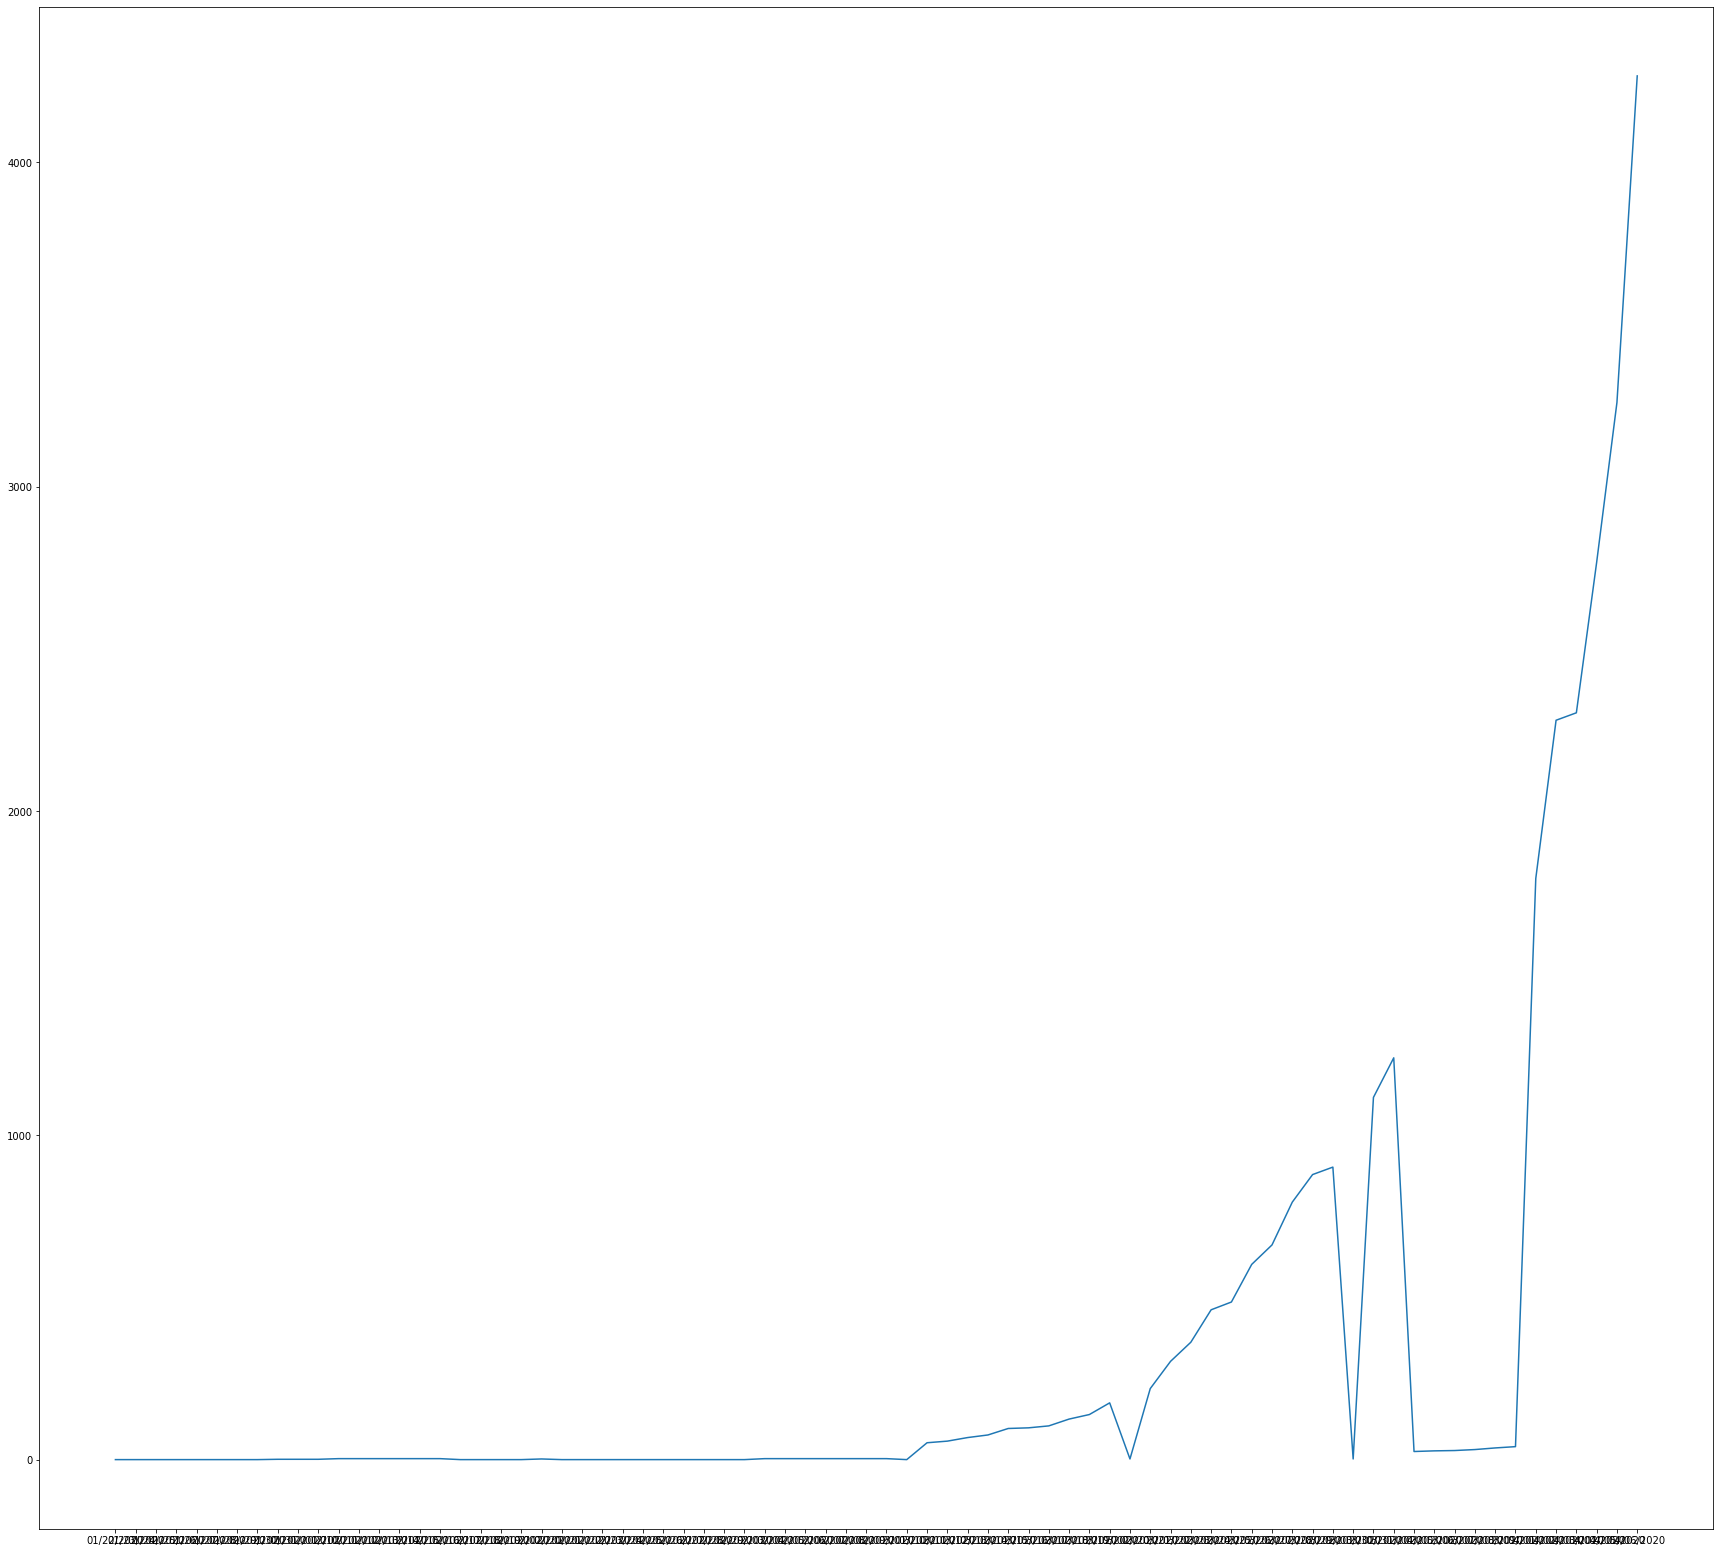

In [53]:
plt.figure(figsize = (30,28))
plt.plot(data['Date'], data['Active'])

<h3>Confirmed Cases Prediction<h3>

In [54]:
pred_cnfrm = df_india.loc[:,["Confirmed"]]

In [55]:
train_data = pred_cnfrm[:len(pred_cnfrm)-7]
test_data = pred_cnfrm[len(pred_cnfrm)-7:]

In [56]:
train_data

,Confirmed
Date,
1/22/20,0
1/23/20,0
1/24/20,0
1/25/20,0
1/26/20,0
...,...
3/26/20,727
3/27/20,887
3/28/20,987


In [57]:
test_data

,Confirmed
Date,
3/31/20,1397
4/1/20,1998
4/2/20,2543
4/3/20,2567
4/4/20,3082
4/5/20,3588
4/6/20,4778


In [58]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [59]:
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
scaled_full_data = scaler.transform(pred_cnfrm)

In [60]:
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data,scaled_test_data, length=n_input, batch_size=1)

In [72]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 64, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(generator, epochs = 200,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/200
64/64 [==============================] - 1s 19ms/step - loss: 0.0481 - val_loss: 9.2821
Epoch 2/200
64/64 [==============================] - 1s 10ms/step - loss: 0.0272 - val_loss: 3.8106
Epoch 3/200
64/64 [==============================] - 1s 10ms/step - loss: 0.0079 - val_loss: 0.0582
Epoch 4/200
64/64 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.2429
Epoch 5/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.1036


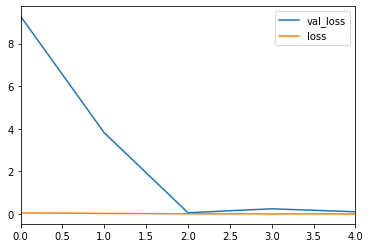

In [73]:
pd.DataFrame(lstm_model.history.history).plot()

In [74]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

confirmed_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
confirmed_prediction

,0
0,1555.574499
1,1829.103242
2,2130.330053
3,2512.327608
4,3032.874406
5,3586.486192
6,4124.208089


<h3>Deaths Predictions<h3>

In [76]:
pred_cnfrm_deaths = df_india.loc[:,["Deaths"]]

In [77]:
train_data_deaths = pred_cnfrm_deaths[:len(pred_cnfrm)-7]
test_data_deaths = pred_cnfrm_deaths[len(pred_cnfrm)-7:]

In [78]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data_deaths)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [79]:
scaled_train_data_deaths = scaler.transform(train_data_deaths)
scaled_test_data_deaths = scaler.transform(test_data_deaths)
scaled_full_data_deaths = scaler.transform(pred_cnfrm_deaths)

In [80]:
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data_deaths,scaled_train_data_deaths, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data_deaths,scaled_test_data_deaths, length=n_input, batch_size=1)

In [96]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 64, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(generator, epochs = 20,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/20
64/64 [==============================] - 2s 28ms/step - loss: 0.0438 - val_loss: 12.0092
Epoch 2/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0288 - val_loss: 6.2020
Epoch 3/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.3231
Epoch 4/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.1699
Epoch 5/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.2617
Epoch 6/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.4902


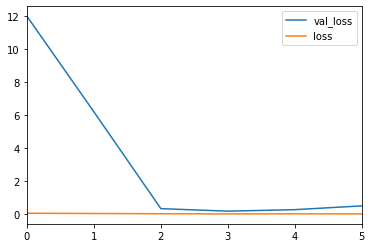

In [97]:
pd.DataFrame(lstm_model.history.history).plot()

In [98]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

deaths_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
deaths_prediction

,0
0,39.697678
1,46.417347
2,53.672260
3,62.653763
4,74.602478
5,86.947792
6,98.618416


<h3>Total Recovered Patients Predictions<h3>

In [99]:
pred_cnfrm_recovered = df_india.loc[:,["Recovered"]]

In [100]:
train_data_recovered = pred_cnfrm_recovered[:len(pred_cnfrm_recovered)-7]
test_data_recovered = pred_cnfrm_recovered[len(pred_cnfrm_recovered)-7:]

In [101]:
early_stop = EarlyStopping(patience = 2, monitor = "val_loss")

scaler = MinMaxScaler()
scaler.fit(train_data_recovered)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [102]:
scaled_train_data_recovered = scaler.transform(train_data_recovered)
scaled_test_data_recovered = scaler.transform(test_data_recovered)
scaled_full_data_recovered = scaler.transform(pred_cnfrm_recovered)

In [103]:
n_input = 5
n_features = 1
                             
generator = TimeseriesGenerator(scaled_train_data_recovered, scaled_train_data_recovered, length=n_input, batch_size=1)

val_generator = TimeseriesGenerator(scaled_test_data_recovered,scaled_test_data_recovered, length=n_input, batch_size=1)

In [106]:
lstm_model = Sequential()

lstm_model.add(LSTM(units = 32, input_shape = (n_input, n_features) ))
lstm_model.add(Dropout(0.4))

lstm_model.add(Dense(units = 1))


lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')

lstm_model.fit(generator, epochs = 20,
              validation_data = val_generator,
              callbacks = [early_stop])

Epoch 1/20
64/64 [==============================] - 1s 18ms/step - loss: 0.0441 - val_loss: 8.3956
Epoch 2/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0224 - val_loss: 5.1852
Epoch 3/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0137 - val_loss: 2.3758
Epoch 4/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.8175
Epoch 5/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.3667
Epoch 6/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0583
Epoch 7/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.2169
Epoch 8/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0130
Epoch 9/20
64/64 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.6649
Epoch 10/20
64/64 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.2265


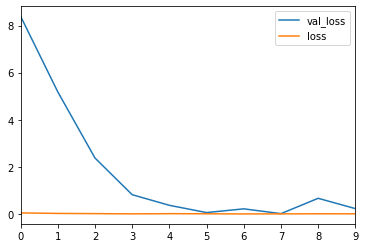

In [107]:
pd.DataFrame(lstm_model.history.history).plot()

In [108]:
lstm_predictions_scaled = []

batch = scaled_train_data_recovered[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(scaled_test_data_recovered)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

recovered_prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
forecast_recovered_prediction = scaler.inverse_transform(lstm_predictions_scaled)
recovered_prediction    

,0
0,143.402165
1,181.487454
2,214.800930
3,252.518156
4,292.325695
5,332.250353
6,358.889709


<h3>Forecasting of Recovered Patients<h3>

In [109]:
forecast_index = pd.date_range(start = '4/7/20', periods = 7, freq = 'D' )

In [110]:
forecast_index

DatetimeIndex(['2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-11', '2020-04-12', '2020-04-13'],
              dtype='datetime64[ns]', freq='D')

In [111]:
forecast_df = pd.DataFrame(data = forecast_recovered_prediction, index = forecast_index, columns = ['RecoveredForecast'])

In [112]:
forecast_df

,RecoveredForecast
2020-04-07,143.402165
2020-04-08,181.487454
2020-04-09,214.800930
2020-04-10,252.518156
2020-04-11,292.325695
2020-04-12,332.250353
2020-04-13,358.889709
